# Modeling human genome at lightning speed

The aim of this notebook is to build a classification model to predict a gene family based on the DNA sequence of the coding sequence.

Gene families are collections of genes that are evolutionarily related, having originated from a common ancestral gene. These genes typically share similar DNA sequences and often retain related biological functions, although they may also evolve new roles over time. Within a gene family, the individual members can be classified based on their evolutionary history into two main types: paralogs and orthologs.

Paralogs are genes that arise through duplication events within the same genome. After duplication, these genes may diverge in function, allowing organisms to develop new traits or regulatory mechanisms. For example, two paralogous genes in humans may perform distinct but complementary roles in cellular processes.

Orthologs, on the other hand, are genes found in different species that evolved from a common ancestral gene due to speciation events. These genes typically retain similar functions across species and are valuable for comparative genomics studies. For instance, a gene in humans and its ortholog in mice may both play essential roles in embryonic development.

Understanding gene families and the relationships between paralogs and orthologs is crucial for studying gene evolution, function, and the conservation of biological processes across different organisms.

## Imports

We will be using GPUs throughtout the notebook.

1. We will use the zero-code change pandas code to run on the GPU.
2. To featurize our dataset -- we will be using the transformer models from Hugging Face.

In [ ]:
!pip install -q --upgrade jupyter ipywidgets

In [ ]:
!pip install -q umap-learn

In [ ]:
import cuml
cuml.accel.install()
import cudf.pandas
cudf.pandas.install()

In [99]:
# %load_ext cudf.pandas
# %load_ext cuml.accel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
from umap import UMAP
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# %matplotlib inline


The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas
The cuml.accel extension is already loaded. To reload it, use:
  %reload_ext cuml.accel


## Let's get the data
The data contains two columns:
1. The genome sequence. It is a complete list of the DNA bases—adenine (A), thymine (T), cytosine (C), and guanine (G)—that make up the genetic material of an organism. It represents the full set of instructions encoded in the DNA, covering all of the organism’s genes as well as non-coding regions that help regulate gene activity or have other structural and functional roles.
2. Class label.

In this particular dataset, the class label stands for the following gene family:

| Class label | Gene family                 | Description                                                                                                                                                     |
|-------------|-----------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 0           | G Protein coupled receptors | Cell surface proteins that detect external signals and activate internal cellular responses by interacting with G proteins.                                     |
| 1           | Tyrosine kinase             | An enzyme that transfers phosphate groups to specific tyrosine residues on proteins, often initiating signal transduction pathways.                             |
| 2           | Tyrosine phosphatase        | An enzyme that removes phosphate groups from phosphorylated tyrosine residues, thereby regulating or turning off signaling pathways.                            |
| 3           | Synthetase                  | An enzyme that catalyzes the joining of two molecules using energy from ATP, often involved in biosynthesis processes like attaching amino acids to tRNA.       |
| 4           | Synthase                    | An enzyme that catalyzes the formation of a chemical bond between molecules to synthesize a compound, typically without requiring energy from ATP.              |
| 5           | Ion channel                 | A gene-encoded protein that forms pores in cell membranes, allowing specific ions to pass in and out, which is critical for cellular signaling and homeostasis. |
| 6           | Transcription factor        | A protein that binds to specific DNA sequences to regulate the transcription of genes, controlling when and how much a gene is expressed.                       |

In [97]:
human_url = 'https://raw.githubusercontent.com/nageshsinghc4/DNA-Sequence-Machine-learning/master/human_data.txt'
human_dna = pd.read_table(human_url)

human_dna.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


Let's check the class frequencies.

<Axes: xlabel='class'>

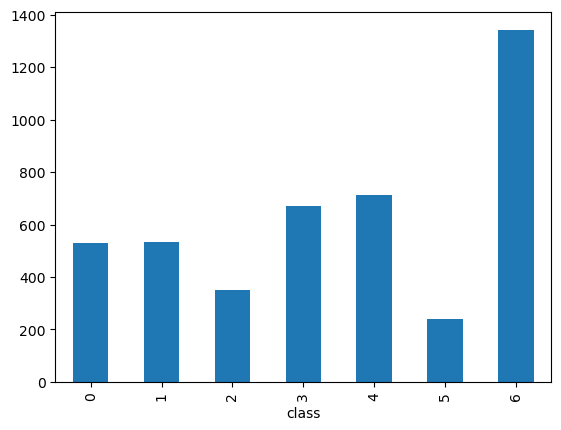

In [98]:
human_dna['class'].value_counts().sort_index().plot.bar()

## Tokenize the gene sequences to create embeddings

We will use the nucleotide transformer from Hugging Face to *convert* the sequences of the adenine, thymine, cytosine, and quanine to a numerical representation. Because the whole dataset would not fit into memory -- we will batch the dataset. This process can take quite a bit of time.

In [5]:
def get_dna_embeddings(sequences, classes):
    # Create a dummy dna sequence and tokenize it
    tokens_ids = tokenizer.batch_encode_plus(sequences, return_tensors="pt", padding="longest")["input_ids"]
    tokens_ids.to('cuda:0')

    # Compute the embeddings
    attention_mask = tokens_ids != tokenizer.pad_token_id
    try:
        torch_outs = model(
            tokens_ids,
            attention_mask=attention_mask,
            encoder_attention_mask=attention_mask,
            output_hidden_states=True
        )
    except:
        return []
    
    # Compute sequences embeddings
    embeddings = torch_outs['hidden_states'][-1].detach()
    
    # Add embed dimension axis
    attention_mask = torch.unsqueeze(attention_mask, dim=-1)
    
    # Compute mean embeddings per sequence
    mean_sequence_embeddings = torch.sum(attention_mask*embeddings, axis=-2)/torch.sum(attention_mask, axis=1)
    return list(zip(mean_sequence_embeddings.numpy(), classes))

# Import the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref")
model = AutoModelForMaskedLM.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref")

# Parameters
genes = []
batch_size=10

# Data prep
human_genes = human_dna['sequence'].tolist()[:1000]
human_classes = human_dna['class'].tolist()[:1000]

# Batch the data
print(len(human_genes))
human_genes = [human_genes[i:i + batch_size] for i in range(0, len(human_genes), batch_size)]
human_classes = [human_classes[i:i + batch_size] for i in range(0, len(human_classes), batch_size)]
print(len(human_genes))

assert len(human_genes) == len(human_classes)

# Create the embeddings
for i in tqdm(range(len(human_genes)), desc='Producing embeddings...'):
    emb = get_dna_embeddings(human_genes[i], human_classes[i])
    genes += emb



Producing embeddings...:   0%|          | 0/438 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1257 > 1000). Running this sequence through the model will result in indexing errors


Now that we have the embeddings -- let's create our final DataFrame.

## Classfiying the genes

In [6]:
genes_df = pd.DataFrame(genes, columns=['embeddings', 'class'])

### Data transformation
In order to use the scikit-learn models -- we need to convert out embeddings into columns. Each embedding has 1280 elements.

In [14]:
genes_df[[f'emb_{i}' for i in range(1280)]] = pd.DataFrame(genes_df['embeddings'].tolist(), index=genes_df.index)

### Random Forest classification model with all columns
We will build a Random Forest model using our full dataset. But first, let's split our dataset into training and testing parts.

In [ ]:
# Splitting the human dataset into the training set and test set
X, y = genes_df[[f'emb_{i}' for i in range(1280)]], genes_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.20,
                                                   random_state=42)

Now we are ready to train our classifier.

In [ ]:
classifier = RandomForestClassifier(n_estimators=200, max_depth=20, max_features=1.0, n_jobs=-1)
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features=1.0, n_estimators=200,
                       n_jobs=-1)

Let's see how well it does. In order to help show the performance -- let's define a helpful method.

In [100]:
def model_performance(y_test, y_pred):
    def get_metrics(y_test, y_predicted):
        accuracy = accuracy_score(y_test, y_predicted)
        precision = precision_score(y_test, y_predicted, average='weighted')
        recall = recall_score(y_test, y_predicted, average='weighted')
        f1 = f1_score(y_test, y_predicted, average='weighted')
        return accuracy, precision, recall, f1
    
    print("Confusion matrix\n")
    print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
           
    accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
    
    print(f"accuracy = {accuracy: .3f} \nprecision = {precision:.3f} \nrecall = {recall:.3f} \nf1 = {f1:.3f}")

In [ ]:
X_test

Now we can see how well our model performs.

In [102]:
classifier.output_type = 'numpy'
y_pred = classifier.predict(X_test)
model_performance(y_test, y_pred)

Confusion matrix

Predicted   0   1   2   3   4   5    6
Actual                                
0          64   3   0   2   6   0   14
1           3  69   0   9  12   0   24
2           3   4  35   5  10   0   15
3           0   2   0  77  16   0   26
4           6   3   0   9  99   0   29
5           5   2   0   2   8  19    5
6           1   2   0   3   4   0  234
accuracy =  0.719 
precision = 0.750 
recall = 0.719 
f1 = 0.712


Overall accuracy > 70% is not too bad. The other metrics are pretty good as well. But we're using a large model with > 1200 columns. Let's try to reduce this using UMAP.

## Random Forest classification with UMAP reduced columns
First, let's define the `reducer`. We will use 200 components thus we expect the final dataset to have 200 columns -- a significant reduction from almost 1300.

In [103]:
reducer = UMAP(n_neighbors=15, min_dist=0.1, n_components=200, metric='euclidean')
reducer.output_type = 'numpy'

embedding = reducer.fit_transform(X)
embedding.shape

Building knn graph using brute force


(4150, 200)

As expected, we have 200 columns. Okay, let's build our model -- note that instead of using `X` variable -- we are now passing the `embedding` one to the `train_test_split` method.

In [105]:
X_train, X_test, y_train, y_test = train_test_split(embedding, y,
                                                   test_size = 0.20,
                                                   random_state=42)

classifier = RandomForestClassifier(n_estimators=200, max_depth=20, max_features=1.0, n_jobs=-1)
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features=1.0, n_estimators=200,
                       n_jobs=-1)

How well did we do?

In [106]:
y_pred = classifier.predict(X_test)
model_performance(y_test, y_pred)

Confusion matrix

Predicted   0   1   2   3   4   5    6
Actual                                
0          58   4   6   5   6   2    8
1           7  71   2   9   8   1   19
2           4   6  29   8   9   1   15
3           1   5   2  76  16   0   21
4           7   7   5  19  88   2   18
5           3   1   1   7   7  18    4
6           2   6   2  20  10   2  202
accuracy =  0.653 
precision = 0.655 
recall = 0.653 
f1 = 0.648


A reduction of ~6 percentage points across the board for a much smaller model. This may be a good trade off. Let's see how XGboost will do with this dataset.

## XGBoost classiciation with UMAP reduced columns
We will train the model using a GPU.

In [119]:
# Specify sufficient boosting iterations to reach a minimum
num_round = 200
xgb.set_config(verbosity=0)
# Leave most parameters as default
clf = xgb.XGBClassifier(device="cuda", n_estimators=num_round)

clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-mlogloss:1.68613
[1]	validation_0-mlogloss:1.54409
[2]	validation_0-mlogloss:1.44845
[3]	validation_0-mlogloss:1.37327
[4]	validation_0-mlogloss:1.32524
[5]	validation_0-mlogloss:1.27839
[6]	validation_0-mlogloss:1.24326
[7]	validation_0-mlogloss:1.21360
[8]	validation_0-mlogloss:1.19338
[9]	validation_0-mlogloss:1.17935
[10]	validation_0-mlogloss:1.16452
[11]	validation_0-mlogloss:1.15331
[12]	validation_0-mlogloss:1.14098
[13]	validation_0-mlogloss:1.13247
[14]	validation_0-mlogloss:1.12727
[15]	validation_0-mlogloss:1.12191
[16]	validation_0-mlogloss:1.11601
[17]	validation_0-mlogloss:1.11201
[18]	validation_0-mlogloss:1.10938
[19]	validation_0-mlogloss:1.10193
[20]	validation_0-mlogloss:1.09547
[21]	validation_0-mlogloss:1.09147
[22]	validation_0-mlogloss:1.08974
[23]	validation_0-mlogloss:1.08356
[24]	validation_0-mlogloss:1.07820
[25]	validation_0-mlogloss:1.07663
[26]	validation_0-mlogloss:1.07381
[27]	validation_0-mlogloss:1.07026
[28]	validation_0-mlogloss:1.0

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [120]:
y_pred = clf.predict(X_test)
model_performance(y_test, y_pred)

Confusion matrix

Predicted   0   1   2   3   4   5    6
Actual                                
0          63   4   4   4   6   0    8
1           6  71   1   7  10   1   21
2           4   2  37   7   8   0   14
3           4   4   4  72  21   1   15
4           7  10   6  17  86   1   19
5           3   1   0   5  10  17    5
6           5   4   5  18  12   4  196
accuracy =  0.653 
precision = 0.656 
recall = 0.653 
f1 = 0.650


The XGboost model achieved a similar performance as the Random Forest on the reduced dataset. Let's see if it can do better on the full dataset.
## XGBoost classifier with full dataset

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.20,
                                                   random_state=42)
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-mlogloss:1.65992
[1]	validation_0-mlogloss:1.49398
[2]	validation_0-mlogloss:1.37583
[3]	validation_0-mlogloss:1.28338
[4]	validation_0-mlogloss:1.22367
[5]	validation_0-mlogloss:1.17340
[6]	validation_0-mlogloss:1.12075
[7]	validation_0-mlogloss:1.07898
[8]	validation_0-mlogloss:1.04353
[9]	validation_0-mlogloss:1.01402
[10]	validation_0-mlogloss:0.99313
[11]	validation_0-mlogloss:0.97097
[12]	validation_0-mlogloss:0.95507
[13]	validation_0-mlogloss:0.93997
[14]	validation_0-mlogloss:0.92445
[15]	validation_0-mlogloss:0.91154
[16]	validation_0-mlogloss:0.90129
[17]	validation_0-mlogloss:0.89332
[18]	validation_0-mlogloss:0.88546
[19]	validation_0-mlogloss:0.87877
[20]	validation_0-mlogloss:0.87097
[21]	validation_0-mlogloss:0.86566
[22]	validation_0-mlogloss:0.85967
[23]	validation_0-mlogloss:0.85530
[24]	validation_0-mlogloss:0.85216
[25]	validation_0-mlogloss:0.84732
[26]	validation_0-mlogloss:0.84216
[27]	validation_0-mlogloss:0.83973
[28]	validation_0-mlogloss:0.8

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [123]:
y_pred = clf.predict(X_test)
model_performance(y_test, y_pred)

Confusion matrix

Predicted   0   1   2   3    4   5    6
Actual                                 
0          70   1   0   3    4   0   11
1           1  77   1   5   10   2   21
2           5   4  40   4    8   0   11
3           2   4   2  89   10   0   14
4           7   4   1  14  103   0   17
5           3   2   0   2    7  22    5
6           6   2   2   6    5   0  223
accuracy =  0.752 
precision = 0.762 
recall = 0.752 
f1 = 0.747


Well, this one does a bit better suggesting that we may indeed keep the full dataset to classify the genes. 